https://chat.deepseek.com/a/chat/s/b693a3a0-dd59-4cc2-b6b7-67484f101d65

In [51]:
from data_loader import load_data
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
import warnings
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor


warnings.filterwarnings(action='ignore')

### 1. Load the data from data `data_loader`:

In [2]:
df = load_data()
df.head(3)

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service,online_security,...,device_protection,tech_support,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,monthly_charges,total_charges,churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes


### 2. EDA:

In [3]:
print(f"There are total of {df.shape[0]} samples and {df.shape[1]} features.")

There are total of 7043 samples and 21 features.


`customer_id` won't be relevant for us, so for now we will drop it.

In [4]:
df = df.drop(columns=['customer_id'])

In [5]:
df.shape

(7043, 20)

In [6]:
df.isna().sum()

gender               0
senior_citizen       0
partner              0
dependents           0
tenure               0
phone_service        0
multiple_lines       0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
contract             0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
churn                0
dtype: int64

We don't have any missing values.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   gender             7043 non-null   object
 1   senior_citizen     7043 non-null   int64 
 2   partner            7043 non-null   object
 3   dependents         7043 non-null   object
 4   tenure             7043 non-null   int64 
 5   phone_service      7043 non-null   object
 6   multiple_lines     7043 non-null   object
 7   internet_service   7043 non-null   object
 8   online_security    7043 non-null   object
 9   online_backup      7043 non-null   object
 10  device_protection  7043 non-null   object
 11  tech_support       7043 non-null   object
 12  streaming_tv       7043 non-null   object
 13  streaming_movies   7043 non-null   object
 14  contract           7043 non-null   object
 15  paperless_billing  7043 non-null   object
 16  payment_method     7043 non-null   object


#### 2.1 Univariate Analysis:

In [8]:
df.value_counts('churn')

churn
No     5174
Yes    1869
Name: count, dtype: int64

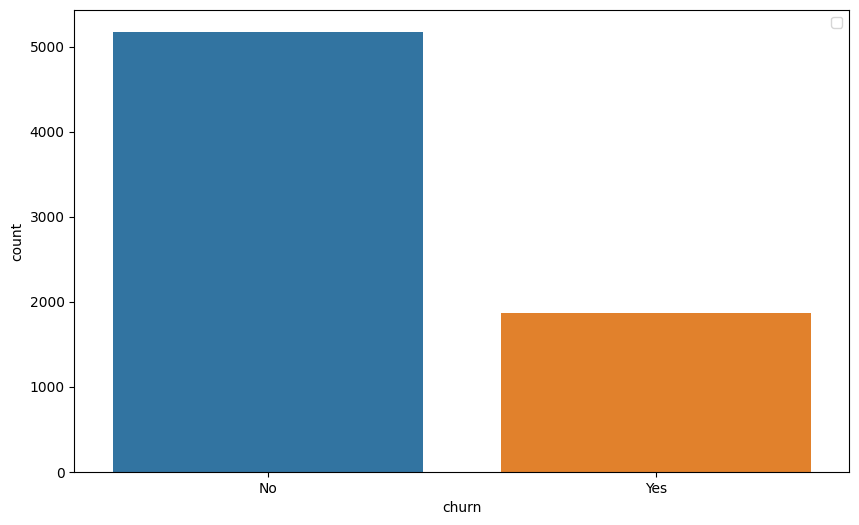

In [9]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='churn', hue='churn')
plt.legend()  
plt.show()

There is an imbalance in the dataset.

So, we will be using this dataset of 3 versions i.e.:
1. The original format
2. Undersampling (Bring down the data of high label count to low label coun)
3. Oversampling (Increase the data of low label count to match the count of the data of the high label.)

and then compare the accuracies and move forward accordingly.

In [10]:
df.head(2)

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,monthly_charges,total_charges,churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No


Converting data types for `monthly_charges` and `total_charges`:

In [11]:
df['monthly_charges'] = pd.to_numeric(df['monthly_charges'], errors='coerce')
df['total_charges'] = pd.to_numeric(df['total_charges'], errors='coerce')

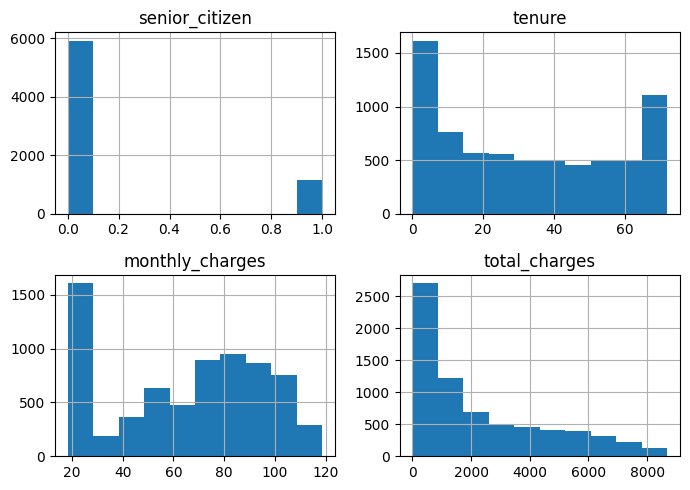

In [12]:
df.hist(figsize=(7, 5))
plt.tight_layout()
plt.show()

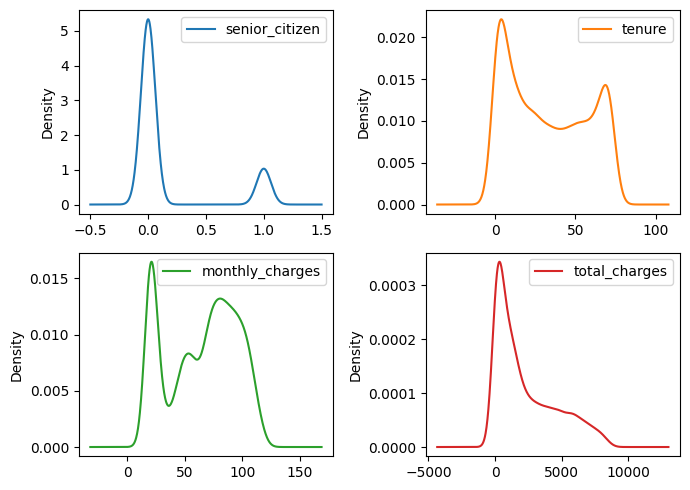

In [13]:
df.plot(kind='density', subplots=True, layout=(2, 2), figsize=(7, 5), sharex=False)
plt.tight_layout()
plt.show()

We can see that most of the clients are young.

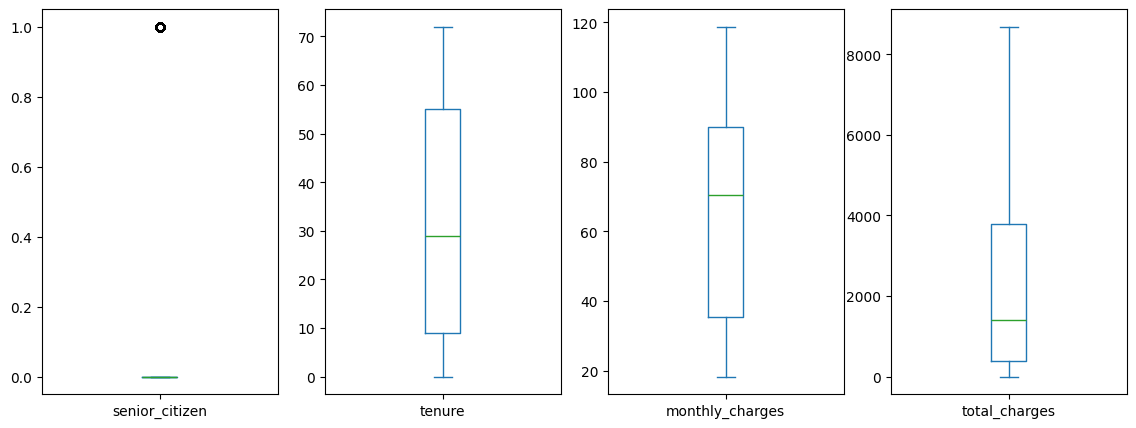

In [14]:
df.plot(kind='box', subplots=True, sharex=False, sharey=False, figsize=(14, 5))
plt.show()

### Gender:

Customer involvement by gender:

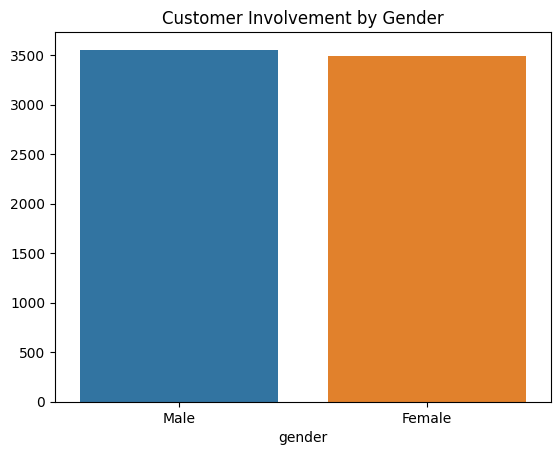

In [15]:
sns.barplot(x=df['gender'].value_counts().index, 
            y=df['gender'].value_counts().values, 
            hue=df['gender'].value_counts().index)
plt.title("Customer Involvement by Gender")
plt.show()

### Contract:

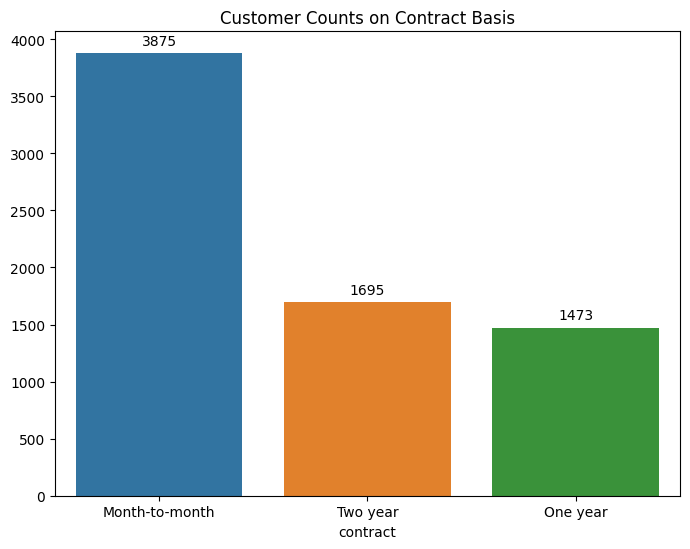

In [16]:
plt.figure(figsize=(7, 5.6))
ax = sns.barplot(x=df['contract'].value_counts().index,
                 y=df['contract'].value_counts().values,
                 hue=df['contract'].value_counts().index
                )


for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', 
                xytext=(0, 9), textcoords='offset points')

plt.title("Customer Counts on Contract Basis")
plt.tight_layout()
plt.show()

This dataset has no any date columns else we could assume how long they have been in the business. If it has been for a short time then this chart shows the company is doing well as the contract for one year and two years are there which shows some level of trust and satisfaction but if the company is old then we need to come up with some strategies to turn customers from month-to-month subscription ot one or more year contract.

### Tenure:

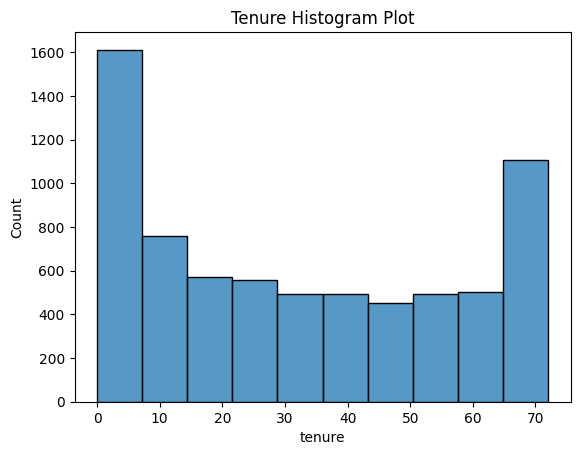

In [17]:
sns.histplot(df['tenure'], bins=10)
plt.title("Tenure Histogram Plot")
plt.show()

Here, is an interesting pattern, there are customers who have been with the company for past 70 months, and there are new batch of customer who are at their first experience ranging from their first to their fifth month of subscription. So, this shows, the company has been running their services for a long time and clears out doubt for earlier chart.

### Customer Marriage Status:

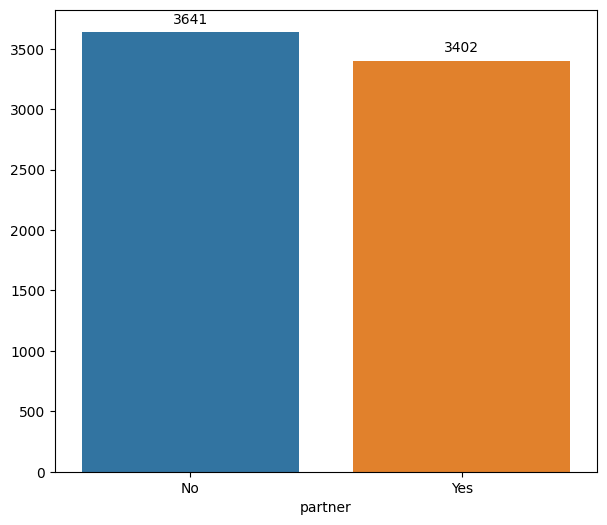

In [18]:
plt.figure(figsize=(7, 6))
ax = sns.barplot(x=df['partner'].value_counts().index,
                y=df['partner'].value_counts().values,
                hue=df['partner'].value_counts().index)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', 
                xytext=(0, 9), textcoords='offset points')
    
plt.show()

## 3. Data Pre-processing:

### 3.1 Convert Churn column to binary data:

In [19]:
df['churn'] = df['churn'].map({"Yes": 1, "No":0})
df['churn'] = df['churn'].astype('object')
df['churn'].value_counts()

churn
0    5174
1    1869
Name: count, dtype: int64

Convert `senior_citizen` data type to object:

In [25]:
df['senior_citizen'] = df['senior_citizen'].astype('object')

### 3.2 Using Chi-Square to find siginificant categorical features:

In [33]:
cat_cols = [col for col in df.select_dtypes(include='object').columns]
significant_cat_cols = []
for col in cat_cols:
    crosstab = pd.crosstab(df[col], df["churn"])
    chi2, p, _, _ = chi2_contingency(crosstab)
    if p < 0.05:
        significant_cat_cols.append(col)
        print(f"{col}: p-value = {p}")
        

senior_citizen: p-value = 1.510066805092378e-36
partner: p-value = 2.1399113440759935e-36
dependents: p-value = 4.9249216612154196e-43
multiple_lines: p-value = 0.0034643829548773
internet_service: p-value = 9.571788222840544e-160
online_security: p-value = 2.6611496351765517e-185
online_backup: p-value = 2.0797592160864276e-131
device_protection: p-value = 5.505219496457244e-122
tech_support: p-value = 1.4430840279998987e-180
streaming_tv: p-value = 5.528994485739183e-82
streaming_movies: p-value = 2.667756755723681e-82
contract: p-value = 5.863038300673391e-258
paperless_billing: p-value = 4.073354668665985e-58
payment_method: p-value = 3.6823546520097993e-140
churn: p-value = 0.0


In [41]:
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.to_list()
total_cols = num_cols + significant_cat_cols

In [42]:
total_cols

['tenure',
 'monthly_charges',
 'total_charges',
 'senior_citizen',
 'partner',
 'dependents',
 'multiple_lines',
 'internet_service',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'contract',
 'paperless_billing',
 'payment_method',
 'churn']

### 3.3 Finding correlation:

#### Encoding the significant categorical columns:

In [43]:
df_encoded = df[total_cols]

for col in significant_cat_cols:
    df_encoded[col] = LabelEncoder().fit_transform(df_encoded[col])
    

In [45]:
df_encoded.head(2)

,tenure,monthly_charges,total_charges,senior_citizen,partner,dependents,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,churn
0,1,29.85,29.85,0,1,0,1,0,0,2,0,0,0,0,0,1,2,0
1,34,56.95,1889.50,0,0,0,0,0,2,0,2,0,0,0,1,0,3,0


#### Finding the correlation:

In [48]:
corr_matrix = df_encoded.corr()  
print(corr_matrix["churn"].sort_values(ascending=False)) 

churn                1.000000
monthly_charges      0.193356
paperless_billing    0.191825
senior_citizen       0.150889
payment_method       0.107062
multiple_lines       0.038037
streaming_tv        -0.036581
streaming_movies    -0.038492
internet_service    -0.047291
partner             -0.150448
dependents          -0.164221
device_protection   -0.178134
online_backup       -0.195525
total_charges       -0.198324
tech_support        -0.282492
online_security     -0.289309
tenure              -0.352229
contract            -0.396713
Name: churn, dtype: float64


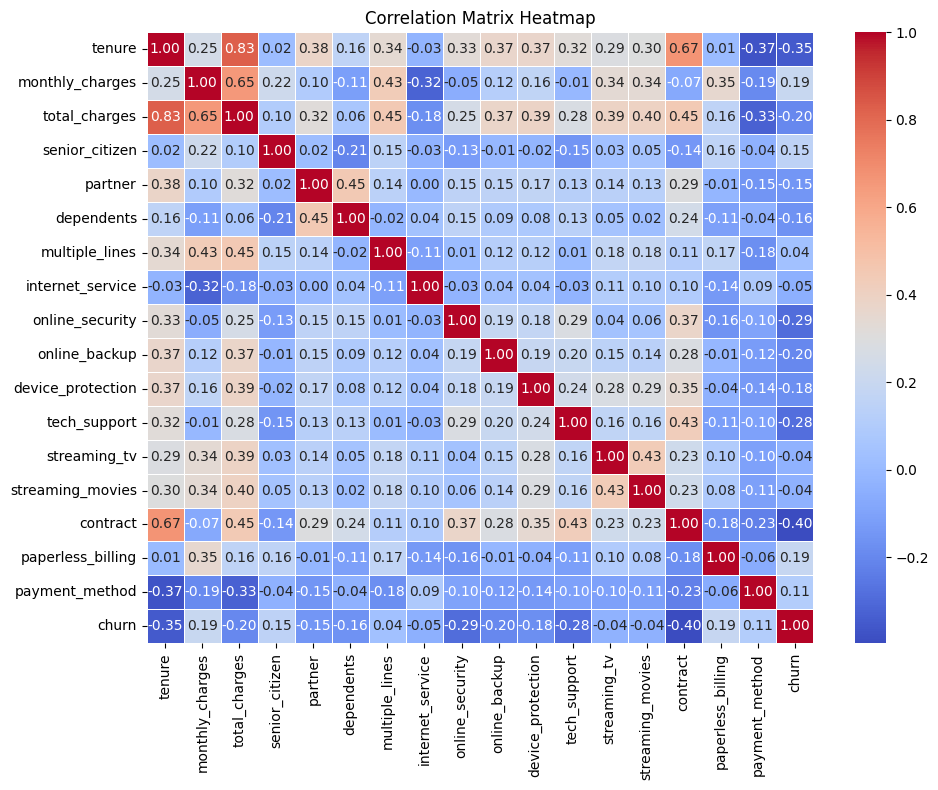

In [50]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5, annot_kws={'size':10})
plt.title('Correlation Matrix Heatmap')
plt.tight_layout()
plt.show()

#### Checking for Multi-collinearity:

In [104]:
total_cols_without_target = total_cols.copy()
total_cols_without_target.remove('churn')

In [105]:
X = df_encoded[total_cols_without_target]

In [106]:
vif_data = pd.DataFrame()
vif_data["Features"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

In [107]:
vif_data

,Features,VIF
0,tenure,14.202715
1,monthly_charges,10.705645
2,total_charges,12.683660
3,senior_citizen,1.365884
4,partner,2.820906
5,dependents,1.958380
6,multiple_lines,2.679552
7,internet_service,2.664332
8,online_security,2.226904
9,online_backup,2.455184


In [108]:
corr = df_encoded[['tenure', 'monthly_charges', 'total_charges']].corr()

In [109]:
corr

,tenure,monthly_charges,total_charges
tenure,1.000000,0.247900,0.826178
monthly_charges,0.247900,1.000000,0.651174
total_charges,0.826178,0.651174,1.000000


`tenure` and `total_charges` have high correlation, so here, I will be dropping `total_charges`

In [115]:
final_cols = total_cols_without_target.copy()
final_cols.remove('total_charges')

In [117]:
X = df_encoded[final_cols]
vif_data = pd.DataFrame()
vif_data["Features"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

In [118]:
vif_data

,Features,VIF
0,tenure,7.456937
1,monthly_charges,8.167970
2,senior_citizen,1.364096
3,partner,2.819413
4,dependents,1.941073
5,multiple_lines,2.673685
6,internet_service,2.362354
7,online_security,2.226542
8,online_backup,2.433950
9,device_protection,2.616763


The `VIF` values now have significantly decreases, now we wil be procedding with these columns.

# 4. Model Building:

In [120]:
X = df_encoded[final_cols]
y = df_encoded['churn']